In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from imblearn.under_sampling import OneSidedSelection, TomekLinks, EditedNearestNeighbours

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv('../datasets/BankChurners.csv')
list = ['Attrition_Flag', 'Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1', 'Contacts_Count_12_mon', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Months_on_book']
data = data[list]
np.random.seed(42)
random.seed(42)

In [6]:
import tensorflow as tf

def metric_precision(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 precision=TP/(TP+FP)
 return precision

def metric_recall(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 recall=TP/(TP+FN)
 return recall

#F1-score    
def metric_F1score(y_true,y_pred): 
 TP=tf.reduce_sum(y_true*tf.round(y_pred))
 TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
 FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
 FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
 precision=TP/(TP+FP)
 recall=TP/(TP+FN)
 F1score=2*precision*recall/(precision+recall)
 return F1score

## onesideselection

In [17]:
input = data.iloc[:,1:]
target = data.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

oss = OneSidedSelection(random_state=42)
x_train, y_train = oss.fit_resample(x_train, y_train)

In [20]:
model = Sequential()

model.add(keras.Input(shape=(8,)))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
	 loss='binary_crossentropy',
	 metrics=['accuracy',
	 		metric_precision,
	 		metric_recall,
	 		metric_F1score,
			 ])
            
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 128)               1152      
                                                                 
 batch_normalization_10 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_11 (Bat  (None, 64)              

In [21]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100,
batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

print('\n Test F1 Score : %.4f' % (model.evaluate(x_test, y_test)[4]))


Epoch 1: val_loss improved from inf to 0.23537, saving model to ./model\01-0.235371.hdf5

Epoch 2: val_loss improved from 0.23537 to 0.18306, saving model to ./model\02-0.183057.hdf5

Epoch 3: val_loss did not improve from 0.18306

Epoch 4: val_loss improved from 0.18306 to 0.17176, saving model to ./model\04-0.171756.hdf5

Epoch 5: val_loss improved from 0.17176 to 0.16439, saving model to ./model\05-0.164390.hdf5

Epoch 6: val_loss did not improve from 0.16439

Epoch 7: val_loss improved from 0.16439 to 0.15904, saving model to ./model\07-0.159037.hdf5

Epoch 8: val_loss did not improve from 0.15904

Epoch 9: val_loss did not improve from 0.15904

Epoch 10: val_loss improved from 0.15904 to 0.15885, saving model to ./model\10-0.158855.hdf5

Epoch 11: val_loss did not improve from 0.15885

Epoch 12: val_loss improved from 0.15885 to 0.15414, saving model to ./model\12-0.154138.hdf5

Epoch 13: val_loss did not improve from 0.15414

Epoch 14: val_loss improved from 0.15414 to 0.14768, 

In [22]:
pred = model.predict(x_test)
pred

array([[0.99329627],
       [0.9999665 ],
       [0.97908187],
       ...,
       [0.9965174 ],
       [0.9021837 ],
       [0.99687016]], dtype=float32)

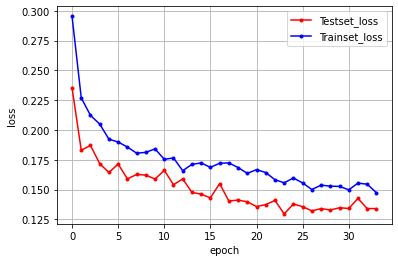

In [23]:
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history["loss"]

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker=".", c="red", label="Testset_loss")
plt.plot(x_len, y_loss, marker=".", c="blue", label="Trainset_loss")

# 그래프에 그리드를 주고 레이블을 표시
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

------------

---------------------

## sampling X

In [24]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(8101, 8) (2026, 8) (8101,) (2026,)


In [27]:
model = Sequential()

model.add(keras.Input(shape=(8,)))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
	 loss='binary_crossentropy',
	 metrics=['accuracy',
	 		metric_precision,
	 		metric_recall,
	 		metric_F1score,
			 ])
            
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_15 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 dense_20 (Dense)            (None, 128)               1152      
                                                                 
 batch_normalization_16 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_17 (Bat  (None, 64)              

In [28]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100,
batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

print('\n Test F1 Score : %.4f' % (model.evaluate(x_test, y_test)[4]))


Epoch 1: val_loss improved from inf to 0.25845, saving model to ./model\01-0.258449.hdf5

Epoch 2: val_loss improved from 0.25845 to 0.20144, saving model to ./model\02-0.201443.hdf5

Epoch 3: val_loss improved from 0.20144 to 0.18289, saving model to ./model\03-0.182886.hdf5

Epoch 4: val_loss improved from 0.18289 to 0.17788, saving model to ./model\04-0.177880.hdf5

Epoch 5: val_loss improved from 0.17788 to 0.17680, saving model to ./model\05-0.176802.hdf5

Epoch 6: val_loss improved from 0.17680 to 0.17394, saving model to ./model\06-0.173945.hdf5

Epoch 7: val_loss did not improve from 0.17394

Epoch 8: val_loss improved from 0.17394 to 0.16443, saving model to ./model\08-0.164433.hdf5

Epoch 9: val_loss improved from 0.16443 to 0.16127, saving model to ./model\09-0.161273.hdf5

Epoch 10: val_loss improved from 0.16127 to 0.15741, saving model to ./model\10-0.157413.hdf5

Epoch 11: val_loss did not improve from 0.15741

Epoch 12: val_loss improved from 0.15741 to 0.15473, saving

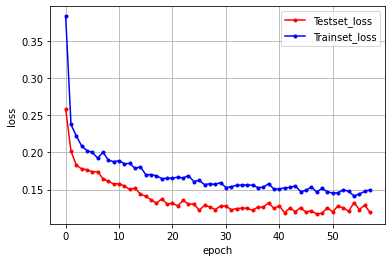

In [29]:
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history["loss"]

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker=".", c="red", label="Testset_loss")
plt.plot(x_len, y_loss, marker=".", c="blue", label="Trainset_loss")

# 그래프에 그리드를 주고 레이블을 표시
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

##### BatchNormalization https://eehoeskrap.tistory.com/430